# Active Subspace Analysis for NACA0012 Airfoil Design

__Paul Constantine__, Colorado School of mines, <pconstan@mines.edu>

__Ryan Howard__, Colorado School of Mines, <ryhoward@mines.edu>

<br>

In this notebook, we'll be summarizing the _active subspaces_ method and its results on the lift and drag of the NACA0012 airfoil, as presented in section 5.3.1 of [[1]][R1].

### Introduction

Engineering and physical models usually contain several parameters whose values can greatly affect the output of the model. It is often of interest how model output changes with changes to parameters, but the number of model evaluations required to characterize this dependence grows exponentially with the dimension of the parameter space; if the model is expensive, it may be practically impossible to obtain enough runs for an exhaustive study. One approach to solving this problem is dimension reduction: reducing the dimension of the parameter space to make traditional methods feasible. _Active subspaces_ is one method of dimension reduction that looks for linear combinations of input parameters whose values are more important to characterizing output than values of orthogonal linear combinations. Here, we'll present the method and apply it to the NACA0012 airfoil.

### Active Subspaces

Consider a model's scalar-valued output, $f$, as a function of $m$ normalized inputs, $\mathbf x:\ f = f(\mathbf x)$. The active subspace method is based on the matrix

$$
\mathbf C = \int\nabla f(\mathbf x)\nabla f(\mathbf x)^T\rho(\mathbf x)\ d\mathbf x = \mathbf W\Lambda\mathbf W^T,
$$

where $\rho$ is a probability density on $\mathbf x$ and $\mathbf W\Lambda\mathbf W^T$ is the eigendecomposition of $\mathbf C$ with the eigenvalues in descending order. The eigenpairs satisfy the relationship $\lambda_i = \int(\nabla f^T\mathbf w_i)^2\rho\ d\mathbf x$; this means the eigenvalues quantify the change of $f$ in the directions defined by the corresponding eigenvectors. If the first $n<m$ eigenvalues are much larger than the rest, we can partition the decompostion as 

$$
\Lambda = \left[\begin{matrix}\Lambda_1 & \\ & \Lambda_2\end{matrix}\right],\ \mathbf W = \left[\begin{matrix}\mathbf W_1 & \mathbf W_2\end{matrix}\right],
$$

where $\Lambda_1$ contains the first $n$ eigenvalues and $\mathbf W_1$ the corresponding eigenvectors. Since the values in $\Lambda_1$ are much larger than those in $\Lambda_2$, $f$ will likely be relatively flat in the directions defined by the span of $\mathbf W_2$ and we can approximate $f(\mathbf x)\approx g(\mathbf W_1^T\mathbf x) = g(\mathbf y)$ for some $g:R^n\rightarrow R$, where $y\equiv \mathbf W_1^T\mathbf x\in R^n$ are called the _active variables_; this reduces the input dimension from $m$ to $n<m$.

Since $\mathbf C$ usually can't be computed analytically, it must be numerically approximated. One method of approximation is simple monte carlo: draw $\{\mathbf x_j\}_{j=1}^M$ from $\rho$, compute $\nabla f_j = \nabla f(\mathbf x_j)\ \forall j$, and then $\mathbf C \approx \frac 1 M\sum_{j=1}^M\nabla f_j\nabla f_j^T$.

### The NACA0012 Airfoil

The NACA0012 airfoil is a standard test problem for flow in 2-dimensional space. The shape of the airfoil is characterized by 18 Hicks-Henne parameters; changes in these quantities continuously alter the geometry. Each parameter has a nominal value in the interval $[-.01, .01]$. For the active subspace analysis, we normalize this parameter space to the hypercube $[-1, 1]^{18}$ and choose $\rho$ to be uniform on this space. Given values of parameters, [SU2](http://su2.stanford.edu/) is used to simulate the fluid flow and to calculate our two quantities of interest (model outputs): lift and drag (each output has a subspace constructed separately from the other), and their gradients with respect to the parameters.

### References

[[1]][R1] P.G. Constantine. _Active Subspaces: Emerging Ideas for Dimension Reduction in Parameter Studies_. SIAM, 2015. ISBN: 978-1-611973-85-3

[[2]][R2] T.W. Lukaczyk, P. Constantine, F. Palacois, and J.J. Alonso. _Active Subspaces for Shape Optimization_. 10th AIAA Multidisciplinary Design Optimization Conference, AIAA SciTech, (AIAA 2014-1171) 

[R1]: http://bookstore.siam.org/sl02/
[R2]: http://dx.doi.org/10.2514/6.2014-1171

### Acknowledgments

This material is based upon work supported by the U.S. Department of Energy Office of Science, Office of Advanced Scientific Computing Research, Applied Mathematics program under Award Number DE-SC-0011077.

<br>

We'll now code up the analysis using the [Python Active-subspaces Utility Library](https://github.com/paulcon/active_subspaces).

In [1]:
import numpy as np
import pandas as pn
import active_subspaces as ac
%matplotlib inline

Import the data set. Distinguish inputs, outputs, and gradients.

In [2]:
#Import the data
df = pn.DataFrame.from_csv('NACA0012.txt')
data = df.as_matrix()

#nominal inputs (X) and outputs (lift and drag)
X = data[:,:18]
lift = data[:,18]
drag = data[:,19]

#gradients with respect to normalized inputs
G_lift = data[:,20:38]
G_drag = data[:,38:]

#M = number of data points, m = number of input parameters
M, m = X.shape

#output labels for plots
labels = df.keys()
out_labels = labels[18:20]

Normalize the inputs to the interval [-1,1].

In [3]:
#lower and upper bounds
xl = -0.01*np.ones((1, m))
xu = 0.01*np.ones((1, m))

#normalized inputs
XX = ac.utils.misc.BoundedNormalizer(xl, xu).normalize(X)

Compute the active subspaces.

In [4]:
#instantiate subspace objects
ss_lift, ss_drag = ac.subspaces.Subspaces(), ac.subspaces.Subspaces()

#Compute the subspaces
ss_lift.compute(df=G_lift, nboot=200)
ss_drag.compute(df=G_drag, nboot=200)

Plot eigenvalues and subspace errors (with ranges from a nonparametric bootstrap procedure).

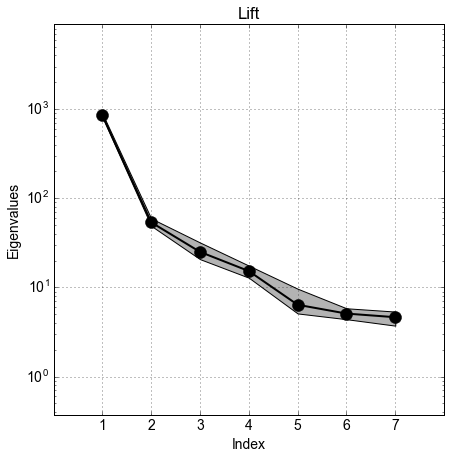

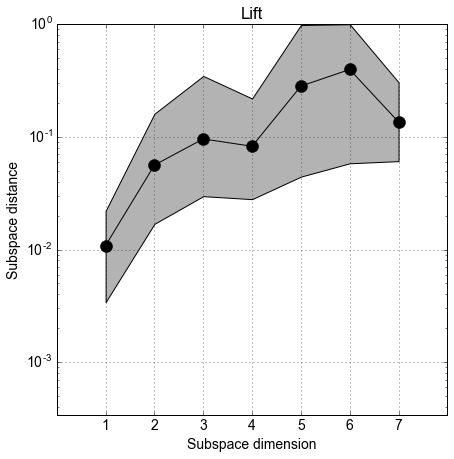

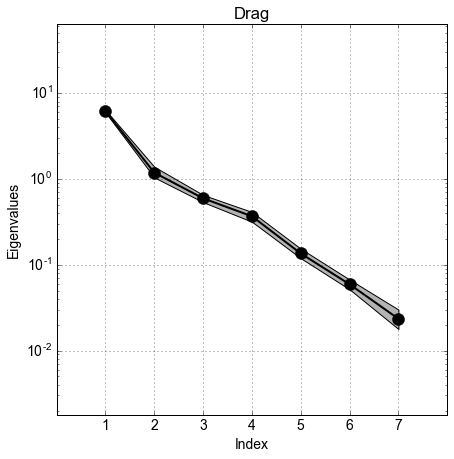

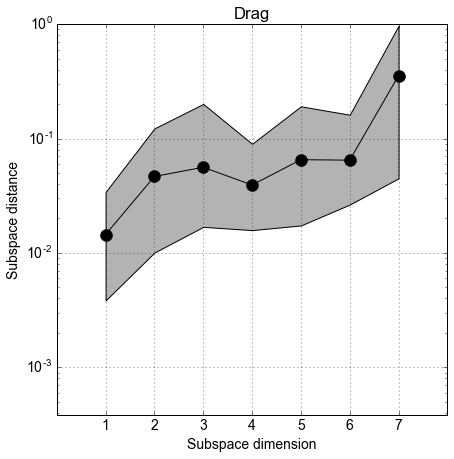

In [5]:
k = 7 #number of eigenvalues to plot

#Plot first k eigenvalues and subspace errors with bootstrap ranges
#For lift
ac.utils.plotters.eigenvalues(ss_lift.eigenvals[:k], ss_lift.e_br[:k,:], out_labels[0])
ac.utils.plotters.subspace_errors(ss_lift.sub_br[:k,:], out_labels[0])
#For drag
ac.utils.plotters.eigenvalues(ss_drag.eigenvals[:k], ss_drag.e_br[:k,:], out_labels[1])
ac.utils.plotters.subspace_errors(ss_drag.sub_br[:k,:], out_labels[1])

In both cases, we see significant declines between the first and second eigenvalues and correspondingly low subspace error associated with the 1-dimensional subspace. However, the eigenvalue gap is smaller for drag than for lift; we might therefore expect a comparatively inaccurate 1-dimensional subspace for drag.

To assess subspace quality, we now construct 1- and 2-dimensional sufficient summary plots, which show output (lift and drag) against the first 1 or 2 active variables ($\mathbf w_1^T\mathbf x$ and $\mathbf w_2^T\mathbf x$); tight trends in these plots indicate good subspace quality.

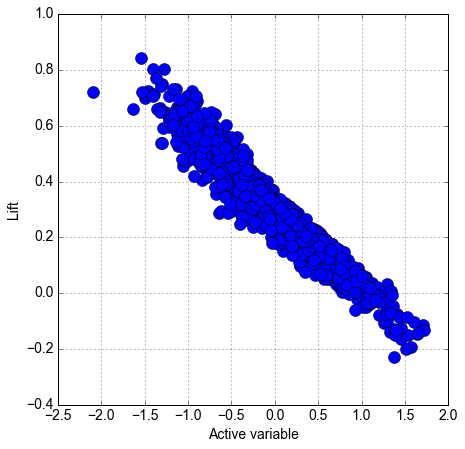

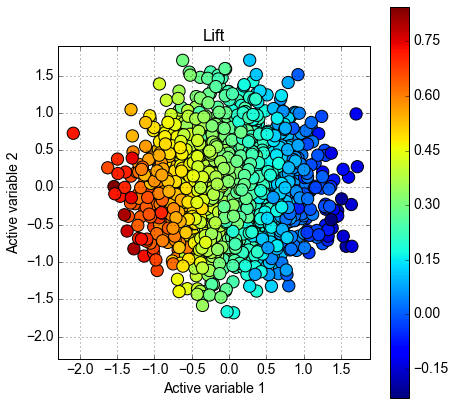

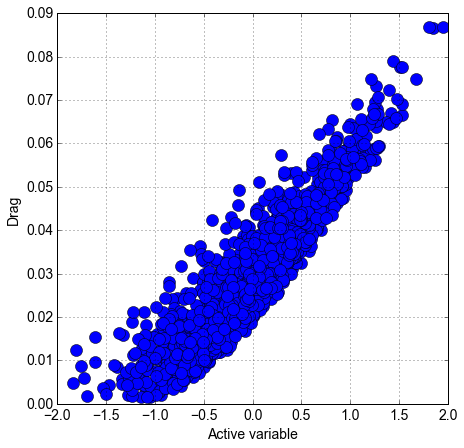

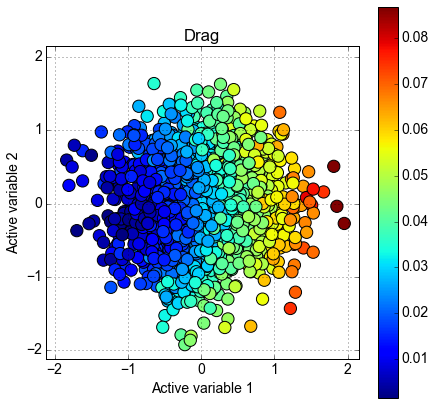

In [6]:
#lists of subspaces and outputs
ss = [ss_lift, ss_drag]; f = [lift, drag]

for i in range(2):
    #make the subspace 2-dimensional for the 2-D plot
    ss[i].partition(2)
    #active variable values
    y = np.dot(XX, ss[i].W1)
    #make the summary plots
    ac.utils.plotters.sufficient_summary(y, f[i], out_labels[i])

We see significant univariate trends in the 1-dimensional plots, though more deviation from this trend is seen for drag than for lift, as the eigenvalues would lead us to expect. While a 1-dimensional plot would likely be sufficient for lift, a 2- or higher-dimensional subspace might be more appropriate for drag.

The eigenvector components provide a measure of sensitivity; higher-magnitude components indicate relative sensitivity to the corresponding parameter. To illustrate the NACA0012 model's sensitivity, we plot the components of the first 2 eigenvectors for lift and drag.

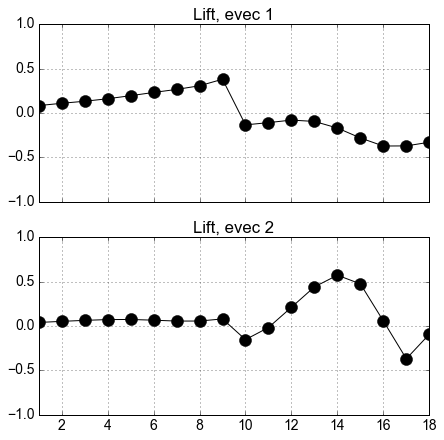

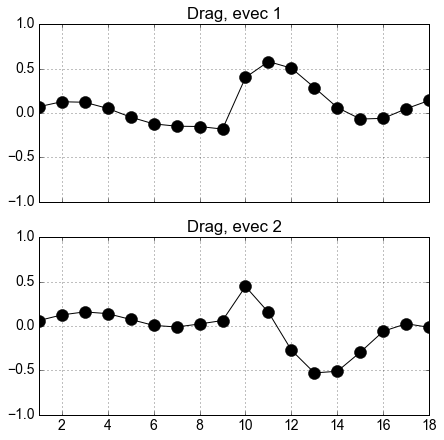

In [7]:
#Plot components of first 2 eigenvectors
ac.utils.plotters.eigenvectors(ss_lift.eigenvecs[:,:2], out_label=out_labels[0])
ac.utils.plotters.eigenvectors(ss_drag.eigenvecs[:,:2], out_label=out_labels[1])

We see (especially for drag) that the last 9 parameters receive higher weight than the first 9. Thus, the geometrical properties determined by the last 9 parameters are those that are most important in determining lift and drag and a wing designer would want to pay close attention to these properties and their uncertainties in order to make accurate predictions about performance.

The active subspaces we've constructed can be used for several applications, such as (constrained) optimization, integration, and surrogate modelling. [[2]][R2] discusses some of these applications in detail regarding the design of the ONERA-M6 wing, a problem similar to what we've discussed here.

[R2]: http://dx.doi.org/10.2514/6.2014-1171